In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [55]:
def generate_synthetic_fico_data(n=100):
    np.random.seed(42)  # For reproducibility
    
    # Simulate Payment History
    # A mix of positive and negative factors
    payment_history = np.random.normal(700, 100, n) - np.random.choice([0, 20, 50, 100], n, p=[0.7, 0.15, 0.1, 0.05])
    
    # Simulate Amounts Owed
    # Influence of credit utilization and total balance
    amounts_owed = 850 - np.random.beta(2, 5, n) * 500  # Beta distribution for utilization skew
    
    # Simulate Length of Credit History
    # Older accounts generally mean higher scores
    length_of_credit_history = np.random.choice(range(300, 850), n, replace=True)
    
    # Simulate Credit Mix
    # More diverse credit types yield higher scores
    credit_mix = np.random.choice(range(600, 850), n, replace=True)
    
    # Simulate New Credit
    # Recent credit activities lower the score
    new_credit = 850 - np.random.gamma(2, 100, n)
    
    # Combine into DataFrame
    data = {
        'Payment History': payment_history,
        'Amounts Owed': amounts_owed,
        'Length of Credit History': length_of_credit_history,
        'Credit Mix': credit_mix,
        'New Credit': new_credit
    }
    df = pd.DataFrame(data) # Divide by 10 to scale down the values
    
    # Calculate FICO Score with given weights
    weights = {'Payment History': 0.45, 'Amounts Owed': 0.20, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
    df['FICO Score'] = df.apply(lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1)
    
    return df


def w(beta, gamma):
    """
    Applies the transformation to beta.
    
    Args:
    beta (float): The input weight.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    float: The transformed weight.
    """
    return np.exp(-(-np.log(beta))**gamma)


def behavioral(weights, gamma):
    """
    Modifies the weights according to the specified formula.
    
    Args:
    weights (np.array): Original model weights.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    np.array: Modified weights reflecting behavioral adjustments.
    """
    sorted_indices = np.argsort(weights)  # Sort indices of weights
    sorted_weights = weights[sorted_indices]  # Sort weights
    transformed_weights = [w(beta, gamma) for beta in sorted_weights]
    
    perceived_weights = np.zeros_like(weights)
    for i in range(len(weights)):
        sum_current = sum(transformed_weights[i:])
        sum_next = sum(transformed_weights[i+1:]) if i+1 < len(weights) else 0
        perceived_weights[sorted_indices[i]] = sum_current - sum_next

    return perceived_weights

In [56]:
# Generate the dataset
df = generate_synthetic_fico_data()
fico_df = df.copy()

In [57]:
# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.1 * (x - 650)))

# Calculate the approval probability for each individual
fico_df['Approval Probability'] = sigmoid(fico_df['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df['True Label'] = (fico_df['Approval Probability'] > np.random.rand(fico_df.shape[0])).astype(int)

fico_df.head(10)

,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score,Approval Probability,True Label
0,749.671415,767.854176,599,799,759.930496,736.666022,0.999828,1
1,686.173570,619.307086,625,622,536.896609,642.279185,0.316029,1
2,764.768854,800.839270,709,646,618.966433,737.160481,0.999836,1
3,852.302986,760.376244,417,689,681.491846,735.210777,0.999801,1
4,626.584663,678.490634,524,645,668.745320,627.635757,0.096527,0
5,676.586304,712.665081,831,706,490.823637,691.329217,0.984217,1
6,857.921282,628.352711,412,739,772.376103,724.672729,0.999429,1
7,756.743473,783.637784,439,817,816.839099,726.496030,0.999524,1
8,653.052561,649.678456,300,740,734.740447,616.283389,0.033193,0
9,654.256004,688.701981,389,703,834.653978,644.270996,0.360568,1


In [58]:
def logistic_regression_with_sum_constraint(X, y):
    """
    Train logistic regression model with the constraint that coefficients sum to 1.
    Args:
    X (pd.DataFrame): Feature dataframe.
    y (pd.Series): Target vector.

    Returns:
    tuple: (coefficients, threshold)
    """
    n_samples, n_features = X.shape
    
    # Variables
    beta = cp.Variable(n_features)
    intercept = cp.Variable()

    # Logistic loss
    logits = X.values @ beta + intercept
    log_likelihood = cp.sum(
        cp.multiply(y.values, logits) - cp.logistic(logits)
    )

    # Objective and constraints
    objective = cp.Maximize(log_likelihood)
    constraints = [cp.sum(beta) == 1, beta >= 0, beta <= 1]

    # Problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return beta.value, intercept.value

# # Example usage to get beta and threshold
# X = pd.DataFrame([[0.1, 0.2], [0.4, 0.5], [0.7, 0.8], [0.3, 0.6], [0.5, 0.9]], columns=['Feature1', 'Feature2'])
# y = pd.Series([0, 1, 0, 0, 1])

# beta, threshold = logistic_regression_with_sum_constraint(X, y)
# print("Beta coefficients:", beta)
# print("Threshold:", threshold)


In [59]:
from sklearn.model_selection import train_test_split

# Example dataset loading
# Assuming 'FICO Score' is not used as a feature directly in the model training
X = fico_df[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']]  # model features
y = fico_df['True Label']  # the target variable

# Splitting the dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

# Train the logistic regression model
beta, threshold = logistic_regression_with_sum_constraint(X_train, y_train)
print("Beta coefficients:", beta)
print("Threshold:", threshold)

# print a few rows of the dataset with predictions and true labels
predictions = (X_test.values @ beta + threshold) > 0  
results = pd.DataFrame({'Prediction': predictions, 'True Label': y_test})
results.head(10)

Beta coefficients: [0.41989216 0.15672575 0.18852142 0.13052504 0.10433562]
Threshold: -640.1260845856747


,Prediction,True Label
83,True,1
53,False,1
70,True,1
45,False,0
44,True,0
39,True,1
22,True,1
80,True,1
10,False,0
0,True,1


In [60]:
# feature names
feature_names = X.columns

# feature weights
coefficients = beta

# Printing feature weights
print("Feature weights:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

    # print perceived weights
perceived_weights = behavioral(coefficients, gamma=0.5)
print("\nPerceived Feature weights:")
for feature, coef in zip(feature_names, perceived_weights):
    print(f"{feature}: {coef:.4f}")

Feature weights:
Payment History: 0.4199
Amounts Owed: 0.1567
Length of Credit History: 0.1885
Credit Mix: 0.1305
New Credit: 0.1043

Perceived Feature weights:
Payment History: 0.3939
Amounts Owed: 0.2563
Length of Credit History: 0.2748
Credit Mix: 0.2400
New Credit: 0.2224


# Optimization

In [61]:
import cvxpy as cp
import numpy as np

def classifier(x, beta, threshold):
    """
    Logistic regression classifier.
    
    Args:
    x : np.array
        Feature vector of the agent.
    beta : np.array
        Weights of the classifier.
    threshold : float
        Threshold for classification.
    
    Returns:
    int
        1 if the agent is classified as positive, 0 otherwise.
    """
    prediction = (x @ beta + threshold) > 0
    return int(prediction)

def cost_function(z, x_0):
    """
    Cost function based on norm-2 distance.
    
    Args:
    z : np.array
        Manipulated feature vector.
    x_0 : np.array
        Original feature vector.
    
    Returns:
    float
        Cost of manipulation.
    """
    return np.linalg.norm(z - x_0)


def agent_optimization(x_0, beta, threshold, R=1, mode='actual', gamma=0.5):
    """
    Solve the agent's optimization problem.
    
    Args:
    x_0 : np.array
        Original feature vector.
    beta : np.array
        Weights of the classifier.
    threshold : float
        Threshold for classification.
    R : float
        Reward for being classified as positive.
    mode : str
        Mode of optimization ('actual' or 'perceived').
    gamma : float
        Gamma parameter for behavioral.
    
    Returns:
    np.array
        Optimized feature vector if conditions are met, otherwise the original feature vector.
    """
    if mode == 'actual':
        weights = beta
    elif mode == 'perceived':
        weights = behavioral(beta, gamma)
    else:
        raise ValueError("Mode should be 'actual' or 'perceived'.")

    z = cp.Variable(len(x_0))
    cost = cp.norm(z - x_0, 2)
    eps = 0.01
    assumed_prediction = cp.sum(cp.multiply(weights, z)) + threshold
    constraints = [assumed_prediction >= eps]
    
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()
    
    optimized_features = z.value

    return optimized_features

    # manipulation_cost = cost_function(optimized_features, x_0)
    # final_prediction = classifier(optimized_features, weights, threshold)

    # if R - manipulation_cost >= 0 and final_prediction == 1:
    #     return optimized_features
    # else:
    #     return x_0


In [62]:
# # Define the initial parameters as pandas Series and numpy arrays
# x_0 = np.array([0.3, 1.5, 0.5])  # Original features of the agent
# beta = np.array([0.8, 0.05, 0.15])  # Weights of the classifier
# threshold = -1  # Classification threshold
# R = 20  # Reward for being classified as positive

# # Perform the classification before manipulation
# initial_classification = classifier(x_0, beta, threshold)
# print(f"Initial classification: {initial_classification}")

# # Solve the agent's optimization problem
# optimized_features = agent_optimization(x_0, beta, threshold, R, mode='actual')
# optimized_features_perceived = agent_optimization(x_0, beta, threshold, R, mode='perceived', gamma=0.5)

# # Perform the classification after manipulation
# final_classification = classifier(optimized_features, beta, threshold)
# print(f"Final classification: {final_classification}")

# final_classification_perceived = classifier(optimized_features_perceived, beta, threshold)
# print(f"Final classification (perceived): {final_classification_perceived}")

# # Print the optimized features and the cost of manipulation
# manipulation_cost = cost_function(optimized_features, x_0)
# print(f"\nOptimized features: {optimized_features}")
# print(f"Cost of manipulation: {manipulation_cost}")

# manipulation_cost_perceived = cost_function(optimized_features_perceived, x_0)
# print(f"\nOptimized features (perceived): {optimized_features_perceived}")
# print(f"Cost of manipulation (perceived): {manipulation_cost_perceived}")

In [63]:
B = 10
beta, threshold = logistic_regression_with_sum_constraint(X_train, y_train)
perceived_weights = behavioral(beta, gamma=0.5)

X_nb = X.copy()
X_b = X.copy()

# Find the agents in X that are closer than B to the decision boundary
# The ones that are closer than B to the decision boundary and classified as negative will optimize
for index_nb, row_nb in X_nb.iterrows():
    if abs(row_nb @ beta + threshold) < B:
        if not classifier(row_nb.values, beta, threshold):
            X_nb.loc[index_nb] = agent_optimization(row_nb.values, beta, threshold, R=1, mode='actual')


for index_b, row_b in X_b.iterrows():
    if abs(row_b @ beta + threshold) < B:
        if not classifier(row_b.values, beta, threshold):
            X_b.loc[index_b] = agent_optimization(row_b.values, beta, threshold, R=1, mode='actual')

/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_66202/2289428978.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '392.78254788976153' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_nb.loc[index_nb] = agent_optimization(row_nb.values, beta, threshold, R=1, mode='actual')
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_66202/2289428978.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '705.6188918647553' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_nb.loc[index_nb] = agent_optimization(row_nb.values, beta, threshold, R=1, mode='actual')
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_66202/2289428978.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error i

In [64]:
print(X.columns)

Index(['Payment History', 'Amounts Owed', 'Length of Credit History',
       'Credit Mix', 'New Credit'],
      dtype='object')


Beta coefficients: [0.78109679 0.21890319]
Threshold: -638.7780942863598

Perceived Feature weights: [0.75266923 0.23295373]


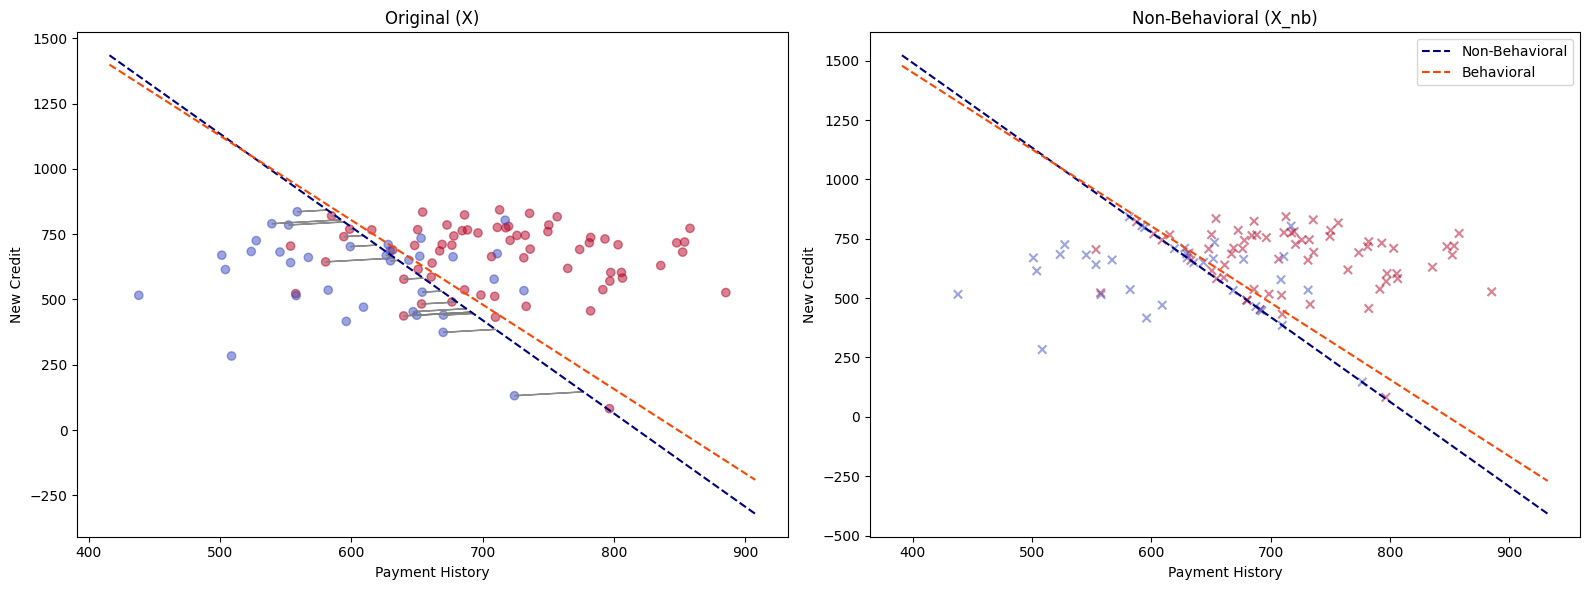

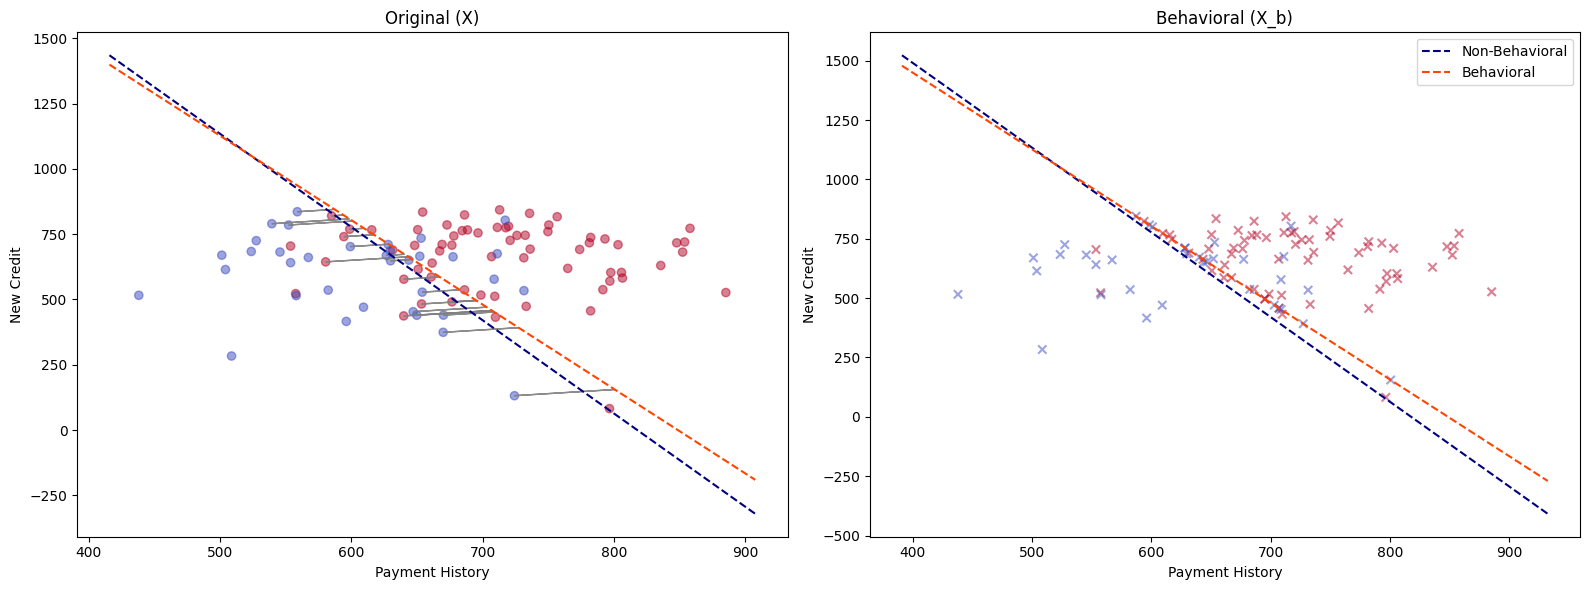

In [65]:
B = 50
gamma_vis = 0.9

feature1='Payment History'
feature2='New Credit'

X_vis = fico_df[[feature1, feature2]]
y_vis = fico_df['True Label']

beta_vis, threshold_vis = logistic_regression_with_sum_constraint(X_vis, y_vis)
perceived_weights_vis = behavioral(beta_vis, gamma=gamma_vis)
print("Beta coefficients:", beta_vis)
print("Threshold:", threshold_vis)

print("\nPerceived Feature weights:", perceived_weights_vis)


X_nb_vis = X_vis.copy()
X_b_vis = X_vis.copy()

# Find the agents in X that are closer than B to the decision boundary
# The ones that are closer than B to the decision boundary and classified as negative will optimize
for index_nb, row_nb in X_nb_vis.iterrows():
    if abs(row_nb @ beta_vis + threshold_vis) < B:
        if not classifier(row_nb.values, beta_vis, threshold_vis):
            X_nb_vis.loc[index_nb] = agent_optimization(row_nb.values, beta_vis, threshold_vis, R=1, mode='actual')


for index_b, row_b in X_b_vis.iterrows():
    if abs(row_b @ beta_vis + threshold_vis) < B:
        if not classifier(row_b.values, beta_vis, threshold_vis):
            X_b_vis.loc[index_b] = agent_optimization(row_b.values, perceived_weights_vis, threshold_vis, R=1, mode='actual')


# Function to create side-by-side scatter plots with movement arrows
def create_side_by_side_plots_with_arrows(dataset1, dataset2, labels, title1, title2, feature1=feature1, feature2=feature2):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot for dataset1
    axs[0].scatter(dataset1[feature1], dataset1[feature2], c=labels, cmap='coolwarm', alpha=0.5)
    axs[0].set_xlabel(feature1)
    axs[0].set_ylabel(feature2)
    axs[0].set_title(title1)

    # plot the line separating the two classes
    x_vals = np.array(axs[0].get_xlim())
    y_vals_nb = -(threshold_vis + beta_vis[0] * x_vals) / beta_vis[1]
    axs[0].plot(x_vals, y_vals_nb, '--', color='navy', label='Non-Behavioral')
    
    # plot the line separating the two classes
    perceived_weights_vis = behavioral(beta_vis, gamma=gamma_vis)
    y_vals_b = -(threshold_vis + perceived_weights_vis[0] * x_vals) / perceived_weights_vis[1]
    axs[0].plot(x_vals, y_vals_b, '--', color='orangered', label='Behavioral')
    

    # Scatter plot for dataset2
    axs[1].scatter(dataset2[feature1], dataset2[feature2], c=labels,  cmap='coolwarm', alpha=0.5, marker='x')
    axs[1].set_xlabel(feature1)
    axs[1].set_ylabel(feature2)
    axs[1].set_title(title2)

    # plot the line separating the two classes
    x_vals = np.array(axs[0].get_xlim())
    y_vals_nb = -(threshold_vis + beta_vis[0] * x_vals) / beta_vis[1]
    axs[1].plot(x_vals, y_vals_nb, '--', color='navy', label='Non-Behavioral')
    
    # plot the line separating the two classes
    perceived_weights_vis = behavioral(beta_vis, gamma=gamma_vis)
    y_vals_b = -(threshold_vis + perceived_weights_vis[0] * x_vals) / perceived_weights_vis[1]
    axs[1].plot(x_vals, y_vals_b, '--', color='orangered', label='Behavioral')
    
    
    
    # Draw arrows
    for i in range(len(dataset1)):
        axs[0].arrow(dataset1[feature1][i], dataset1[feature2][i],
                     dataset2[feature1][i] - dataset1[feature1][i], dataset2[feature2][i] - dataset1[feature2][i],
                     color='gray', alpha=0.9, head_width=0.02, head_length=0.02)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Create the side-by-side scatter plots with arrows
create_side_by_side_plots_with_arrows(X_vis, X_nb_vis, y_vis, 'Original (X)', 'Non-Behavioral (X_nb)')
create_side_by_side_plots_with_arrows(X_vis, X_b_vis, y_vis, 'Original (X)', 'Behavioral (X_b)')
# create_side_by_side_plots_with_arrows(X_nb, X_b, y, 'Non-Behavioral (X_nb)', 'Behavioral (X_b)')

In [17]:
def update_dataset(X, y, beta, threshold, R, mode='actual', gamma=0.5):
    """
    Update the dataset by optimizing features for agents classified as 0.
    
    Args:
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series
        Target variable.
    beta : np.array
        Weights of the classifier.
    threshold : float
        Threshold for classification.
    R : float
        Reward for being classified as positive.
    mode : str
        Mode of optimization ('actual' or 'perceived').
    gamma : float
        Gamma parameter for behavioral.
    
    Returns:
    pd.DataFrame
        Updated feature matrix.
    pd.Series
        Updated target variable.
    """
    X_new = X.copy()
    for i in range(len(X)):
        if classifier(X.iloc[i], beta, threshold) == 0:
            optimized_features = agent_optimization(X.iloc[i], beta, threshold, R, mode, gamma)
            X_new.iloc[i] = optimized_features
    return X_new, y

def iterative_optimization(X, y, mode='actual', gamma=0.5, max_iter=20, R=2.0, tol=1e-4):
    """
    Iteratively optimize features for agents and retrain the model.
    
    Args:
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series
        Target variable.
    mode : str
        Mode of optimization ('actual' or 'perceived').
    gamma : float
        Gamma parameter for behavioral.
    max_iter : int
        Maximum number of iterations.
    R : float
        Reward for being classified as positive.
    tol : float
        Tolerance for convergence.
    
    Returns:
    np.array
        Final weights of the logistic regression model.
    float
        Final threshold for classification.
    """
    beta, threshold = logistic_regression_with_sum_constraint(X, y)
    
    for iteration in range(max_iter):
        X_new, y_new = update_dataset(X, y, beta, threshold, R, mode, gamma)
        beta_new, threshold_new = logistic_regression_with_sum_constraint(X_new, y_new)
        
        if np.linalg.norm(beta_new - beta) < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break
        
        beta, threshold = beta_new, threshold_new
    
    return beta, threshold

In [143]:
# # Run the iterative optimization process with perceived weights
# beta_final_perceived, threshold_final_perceived = iterative_optimization(X, y, mode='perceived')

# # Print the final weights and threshold
# print(f"Final weights (perceived): {beta_final_perceived}")
# print(f"Final threshold (perceived): {threshold_final_perceived}")

# # Run the iterative optimization process with actual weights
# beta_final_actual, threshold_final_actual = iterative_optimization(X, y, mode='actual')

# # Print the final weights and threshold
# print(f"Final weights (actual): {beta_final_actual}")
# print(f"Final threshold (actual): {threshold_final_actual}")